# Sanfrancisco Bikeshare - Data Analysis

-----

In this project, I will answer some business-driven questions using the public datasets housed in the Google Cloud Platform (GCP). The main objectives is to offer recommendations to increase ridership, and improve profits for Lyft Bay Wheels (https://www.lyft.com/bikes/bay-wheels), formerly known as Ford GoBike, the company running Bay Area Bikeshare.

This project has been broken down into 3 parts:

- In Part 1, I will query using the Google BigQuery GUI interface in the cloud.

- In Part 2, I will query using the Linux command line from my virtual machine in the cloud.

- In Part 3, I will query from a Jupyter Notebook in my virtual machine in the cloud, save the results into Pandas, and present a report enhanced by Pandas output tables and perform data visualizations using Seaborn / Matplotlib.


The Bay Bike Share has two datasets: a static one and a dynamic one.  The static one covers an historic period of about 3 years. The dynamic one updates about every 10 minutes.  THE STATIC ONE IS THE ONE I WILL USE IN THE PROJECT. The static tables could be found in the dataset **san_francisco**, they include:

  * bikeshare_stations

  * bikeshare_status

  * bikeshare_trips


## Part 1 - Querying Data with BigQuery

### Some initial queries

- What's the size of this dataset? (i.e., how many trips)
  * Answer:
  
    | number_of_trips |
    | :-------------: |
    | 936648          |

  * SQL query:  
    ```sql
    SELECT COUNT(*) AS number_of_trips
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`;
    ```

- What is the earliest start date and time and latest end date and time for a trip?
  * Answer:

    | earliest_start_date      | latest_start_date       |
    | :----------------------: | :---------------------: |
    | 2013-08-29 09:08:00 UTC  | 2016-08-31 23:32:00 UTC |

     *Note:* Even though the raw data show the timestamp is in UTC, but it is actually already in PST as per findings in a Question below.

  * SQL query:
      ```sql
      SELECT
          MIN(start_date) AS earliest_start_date,
          MAX(start_date) AS latest_start_date
      FROM `bigquery-public-data.san_francisco.bikeshare_trips`;
      ```

- How many bikes are there?
  * Answer:
  
    | total_bikes |
    |:-----------:|
    | 700         |

  * SQL query:
    ```SQL
    SELECT COUNT(DISTINCT bike_number) as total_bikes
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`;
  
 - At which hours do we have the most trips (start_hour)? Does the hour make sense and already in PST or do we need to convert the timestamp from UTC to PST? Only listed the top 10.
  * Answer: 8am & 5pm
      - The hours with the most trips: happened between 7am to 10am, and between 3pm to 6 pm.
      - Even the timestamp listed in UTC in the raw data, the hours with the most trips indicate that the timestamp was actually in correct time PST instead. If we convert from UTC to PST, the busiest hours happened during mid night and did not make sense. Therefore, we will not convert the timestamp in this analysis.

      | start_hour_raw | hour_UTC_to_PST | trip_count | percent |
      | :------------: | :-------------: | :--------: | :------:|
      | 8              | 1               | 132464     | 13.47   |
      | 17             | 10              | 126302     | 12.84   |
      | 9              | 2               | 96118      | 9.77    |
      | 16             | 9               | 88755      | 9.02    |
      | 18             | 11              | 84569      | 8.6     |
      | 7              | 0               | 67531      | 6.87    |
      | 15             | 8               | 47626      | 4.84    |
      | 12             | 5               | 46950      | 4.77    |
      | 13             | 6               | 43714      | 4.44    |
      | 10             | 3               | 42782      | 4.35    |

  * SQL query:
    ```SQL
    WITH t1 AS
    (SELECT
        EXTRACT(HOUR FROM start_date) AS start_hour_raw,
        COUNT(trip_id) AS trip_count
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    GROUP BY start_hour_raw
    )
    SELECT
        start_hour_raw,
        (start_hour_raw - 7) AS hour_UTC_to_PST,
        trip_count,
        ROUND(100*trip_count / (SELECT SUM(trip_count) FROM t1), 2) AS percent
    FROM t1
    ORDER BY trip_count DESC;
    ```

- How long does a trip normally last (trip duration)?
  * Answer:
   - Most of the trips were less than 15 minutes, then follow by 15-30 minutes.
   - Observation: The percentage of all trips > 30mins are significant less than trips with <= 30mins.

    | duration | trip_count | percent |
    |:-------: | :---------:| :------:|
    | 2 - 15 mins  | 818637 | 83.22   |
    | 15 - 30 mins | 110135 | 11.2    |
    | 30 - 45 mins | 12906  | 1.31    |
    | <2 mins      | 7539   | 0.77    |
    | 1 - 1.5hrs   | 7225   | 0.73    |
    | 45 - 60 mins | 6340   | 0.64    |
    | 2 - 3 hrs    | 5630   | 0.57    |
    | 3 - 5 hrs    | 5482   | 0.56    |
    | 1.5 - 2 hrs  | 4665   | 0.47    |
    | 5 - 10 hrs   | 3453   | 0.35    |
    | >10 hrs      | 1636   | 0.17    |    

  * SQL query:
  ```SQL
  WITH t1 AS
  (SELECT
      CASE
          WHEN (duration_sec/60) < 2 THEN '<2 mins'
          WHEN (duration_sec/60) BETWEEN 2 AND 15 THEN '15 - 30 mins'
          WHEN (duration_sec/60) BETWEEN 15 AND 30 THEN '15 - 30 mins'
          WHEN (duration_sec/60) BETWEEN 30 AND 45 THEN '30 - 45 mins'
          WHEN (duration_sec/60) BETWEEN 45 AND 60 THEN '45 - 60 mins'
          WHEN (duration_sec/60) BETWEEN 60 AND 90 THEN '1 - 1.5hrs'
          WHEN (duration_sec/60) BETWEEN 90 AND 120 THEN '1.5 - 2 hrs'
          WHEN (duration_sec/60) BETWEEN 120 AND 180 THEN '2 - 3 hrs'
          WHEN (duration_sec/60) BETWEEN 180 AND 300 THEN '3 - 5 hrs'
          WHEN (duration_sec/60) BETWEEN 300 AND 600 THEN '5 - 10 hrs'      
          ELSE '>10 hrs' END AS duration,
      COUNT(trip_id) AS trip_count,
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
  GROUP BY duration
  )
  SELECT *,
      ROUND(100*trip_count / (SELECT SUM(trip_count) FROM t1), 2) AS percent
  FROM t1
  ORDER BY trip_count DESC;
  ```

- What day of the week having the most trips between 7am-10am and 3pm-6pm hour with the trip duration more than 2 mins and less than 10hrs?
    * Answer: Tuesday, Wednesday
     - Observation: Saturday and Sunday have the least trips.
     
     |  weekday  | trip_count | percent |
     |:---------:|:----------:|:-------:|
     |  Tuesday  |   134060   |   19.7  |
     | Wednesday |   130620   |  19.19  |
     |  Thursday |   125859   |  18.49  |
     |   Monday  |   124911   |  18.35  |
     |   Friday  |   112760   |  16.57  |
     |  Saturday |    28081   |   4.13  |
     |   Sunday  |    24348   |   3.58  |

  * SQL query:
  ```SQL
  WITH t1 AS
    (SELECT
        EXTRACT(DAYOFWEEK FROM start_date) AS weekday,
        COUNT(trip_id) AS trip_count
    FROM(
        SELECT *
        FROM `bigquery-public-data.san_francisco.bikeshare_trips`
        WHERE (EXTRACT(HOUR FROM start_date) IN (7,8,9,10,15,16,17,18))
        AND (duration_sec/60) > 2 AND (duration_sec/60) < 600
        )
    GROUP BY weekday
    )
    SELECT
        CASE weekday
            WHEN 1 THEN 'Sunday'
            WHEN 2 THEN 'Monday'
            WHEN 3 THEN 'Tuesday'
            WHEN 4 THEN 'Wednesday'
            WHEN 5 THEN 'Thursday'
            WHEN 6 THEN 'Friday'
            WHEN 7 THEN 'Saturday'
        END AS weekday, trip_count,
        ROUND(100*trip_count / (SELECT SUM(trip_count) FROM t1), 2) AS percent
    FROM t1
    ORDER BY trip_count DESC;
  ``
    
## Part 2 - Querying data from the BigQuery CLI 

- How many trips are in the morning vs in the afternoon?
    - Answer:
      * Assumption: Morning time is between 6am to 12pm and Afternoon is between 12pm to 6pm

    | time      | trip_count |
    |:---------:|:----------:|
    | afternoon | 428818     |
    | morning   | 446771     |

    - Query:
    ```
    bq query --use_legacy_sql=false '
      SELECT
        CASE
            WHEN EXTRACT(HOUR FROM start_date) BETWEEN 6 AND 12 THEN "morning"
            WHEN EXTRACT(HOUR FROM start_date) BETWEEN 12 AND 18 THEN "afternoon"
        END AS time,
        COUNT(trip_id) AS trip_count
      FROM `bigquery-public-data.san_francisco.bikeshare_trips`
      GROUP BY time
      HAVING time IS NOT NULL'
    ```
    
- How many commuter trips in the dataset?
  * Answer:
    - Assumption: Commuter trips are trips having start_hour between 7am-10am and between 3pm-6pm, with the trip duration more than 2 minutes and less than 10 hours per trip, and it does not include weekends (Saturday & Sunday). Data includes some public holidays with the assumption that trips happened during these holidays were not significant (or negligible) and would not affect the outcomes of the analysis.
    
    | commuter_trip_number |
    |:--------------------:|
    | 628210               |

  * Query:
  ```
  bq query --use_legacy_sql=false '
  SELECT COUNT(*) As commuter_trip_number
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
  WHERE (EXTRACT(HOUR FROM start_date) IN(7,8,9,10,15,16,17,18))
      AND (duration_sec/60) > 2 AND (duration_sec/60) < 600
      AND EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7)'
  ```
  
- Does the station_id and station_name recorded properly in the bikeshare_trips?
  * Answer: No. Some trips has station names different than the name recorded in the bike_share_stations data. Below is the table with different station names in the bikeshare_trips and bike_share_stations.

  | start_station_id |           start_station_name          |          proper_station_name         | different_record_number |
  |:----------------:|:-------------------------------------:|:------------------------------------:|:-----------------------:|
  |        47        |             Post at Kearny            |            Post at Kearney           |          11308          |
  |        46        |          Washington at Kearny         |         Washington at Kearney        |           7136          |
  |        30        |          Evelyn Park and Ride         |    Middlefield Light Rail Station    |           1738          |
  |        33        | Rengstorff Avenue / California Street | Charleston Park/ North Bayshore Area |           1171          |
  |        26        |            Kaiser Hospital            |      Redwood City Medical Center     |           147           |
  |        83        |                 Mezes                 |              Mezes Park              |           119           |
  |        89        |        S. Market St at Park Ave       |       S. Market st at Park Ave       |            84           |
  |        25        |            Broadway at Main           |       Stanford in Redwood City       |            67           |
  |        80        |       San Jose Government Center      |    Santa Clara County Civic Center   |            23           |
  |        88        |      5th S at E. San Salvador St      |     5th S. at E. San Salvador St     |            19           |
  |        21        |            Sequoia Hospital           |           Franklin at Maple          |            15           |
  |        88        |      5th St at E. San Salvador St     |     5th S. at E. San Salvador St     |            1            |

  * Query:
  ```
  bq query --use_legacy_sql=false '
  WITH t1 AS
    (SELECT t1.start_station_id, t1.start_station_name, t2.name as proper_station_name
    FROM `bigquery-public-data.san_francisco.bikeshare_trips` t1
    INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` t2
    ON t1.start_station_id = t2.station_id
    WHERE t1.start_station_name <> t2.name
    )
  SELECT start_station_id, start_station_name, station_name,
      COUNT(station_name) as different_record_number
  FROM t1
  GROUP BY start_station_id, start_station_name, station_name
  ORDER BY different_record_number DESC'
  ```
  
- What is the trip duration in minutes and trip cost for each trip (with updated proper station names)?
  * Assumption: To calculate the trip cost for a single trip, the current pricing schedule from Lyft Bay Wheels was used:
    - For Subscriber:  \\$0 for 45 mins, then \\$2 per additional 15 mins
    - For Customer: \\$3 for 30 mins, then \\$3 per additional 15 mins
  * Answer: the results of this query was saved as a view (view name bikeshare_trips_adj) for further data analysis. Below is the top 5 rows of this view.

  | Row | trip_id | duration_min | trip_cost |        start_date       | start_station_id | start_station_name |         end_date        | end_station_id | end_station_name | bike_number | zip_code | subscriber_type |
  |:---:|:-------:|:------------:|:---------:|:-----------------------:|:----------------:|:------------------:|:-----------------------:|:--------------:|:----------------:|:-----------:|:--------:|:---------------:|
  |  1  |  944732 |     43.6     |    6.0    | 2015-09-24 17:22:00 UTC |        83        |     Mezes Park     | 2015-09-24 18:06:00 UTC |       83       |    Mezes Park    |     653     |   94063  |     Customer    |
  |  2  |  984595 |     99.3     |    18.0   | 2015-10-25 18:12:00 UTC |        83        |     Mezes Park     | 2015-10-25 19:51:00 UTC |       83       |    Mezes Park    |      52     |    nil   |     Customer    |
  |  3  |  984596 |     98.5     |    18.0   | 2015-10-25 18:13:00 UTC |        83        |     Mezes Park     | 2015-10-25 19:51:00 UTC |       83       |    Mezes Park    |     121     |    nil   |     Customer    |
  |  4  | 1129385 |     101.3    |    18.0   | 2016-03-18 10:33:00 UTC |        83        |     Mezes Park     | 2016-03-18 12:14:00 UTC |       83       |    Mezes Park    |     208     |   94070  |     Customer    |
  |  5  | 1030383 |     96.3     |    18.0   | 2015-12-06 10:52:00 UTC |        83        |     Mezes Park     | 2015-12-06 12:28:00 UTC |       83       |    Mezes Park    |      44     |   94064  |     Customer    |

  * Query:
  ```
  bq query --use_legacy_sql=false '  
  WITH t1 AS
      (SELECT *, ROUND(duration_sec/60,1) as duration_min,
          CASE
              WHEN subscriber_type = 'Subscriber' AND duration_sec/60 <= 45
              THEN 0
              WHEN subscriber_type = 'Subscriber' AND duration_sec/60 > 45
              THEN CEILING((duration_sec/60 - 45)/15)*2
              WHEN subscriber_type = 'Customer' AND duration_sec/60 <= 30
              THEN 3
              ELSE 3 + CEILING((duration_sec/60 - 30)/15)*3
          END AS trip_cost
      FROM `bigquery-public-data.san_francisco.bikeshare_trips`
      )
  SELECT t1.trip_id, t1.duration_min, t1.trip_cost, t1.start_date,
      t1.start_station_id, t2.name as start_station_name, t1.end_date, t1.end_station_id,
      t3.name as end_station_name, t1.bike_number, t1.zip_code, t1.subscriber_type,
  FROM (t1 INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` t2
      ON t1.start_station_id = t2.station_id)
      INNER JOIN
      (SELECT station_id, name FROM `bigquery-public-data.san_francisco.bikeshare_stations`) t3
      ON t1.end_station_id = t3.station_id'
  ```

- What start stations have the most commuter trips (top 5) originated from and how much different between subscriber type?
  * Answer: start_station_id 70, 69, 55, 50, 74
  
  |               start_station_name              | start_station_id | total_trips | subscriber_trips | customer_trips |
  |:---------------------------------------------:|:----------------:|:-----------:|:----------------:|:--------------:|
  |    San Francisco Caltrain (Townsend at 4th)   |        70        |    56047    |       54185      |      1862      |
  |    San Francisco Caltrain 2 (330 Townsend)    |        69        |    44065    |       42926      |      1139      |
  | Temporary Transbay Terminal (Howard at Beale) |        55        |    30917    |       30419      |       498      |
  |      Harry Bridges Plaza (Ferry Building)     |        50        |    30002    |       26733      |      3269      |
  |               Steuart at Market               |        74        |    27708    |       26203      |      1505      |

  * Query:
  ```
  bq query --use_legacy_sql=false '
  WITH commuter_trips AS
      (SELECT *
      FROM `gold-access-312519.project1.bikeshare_trips_adj`
      WHERE (EXTRACT(HOUR FROM start_date) IN(7,8,9,10,15,16,17,18))
          AND duration_min > 2 AND duration_min <600
          AND EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7)
      ),
      t2 AS
      (SELECT start_station_name, start_station_id,
      COUNT(trip_id) as total_trips
      FROM commuter_trips
      GROUP BY start_station_name, start_station_id    
      ),
      t3 AS
      (SELECT start_station_id,subscriber_type,
      COUNT(trip_id) as subscriber_trips,
      FROM commuter_trips
      GROUP BY start_station_id, subscriber_type
      HAVING subscriber_type = "Subscriber"
      )
  SELECT t2.start_station_name, t2.start_station_id,
      t2.total_trips, t3.subscriber_trips,
      (t2.total_trips - t3.subscriber_trips) AS customer_trips
  FROM t2 INNER JOIN t3 ON t2.start_station_id = t3.start_station_id
  ORDER BY total_trips DESC
  LIMIT 5'
  ```
  
- What are the bike utilization rates in average by hour for each station during weekdays (Monday - Friday) and from 7am to 6pm
  * Answer: (Only listed 5 records)
    - Assumption: utilization_rate = docks_available*100 / dock_count
    
    | station_id | hour | bikes_available | docks_available | dockcount | utilization_rate |
    |:----------:|:----:|:---------------:|:---------------:|:---------:|:----------------:|
    |     91     |   7  |       7.0       |       28.0      |     35    |       80.0       |
    |     90     |   7  |       8.0       |       23.0      |     31    |       74.19      |
    |     62     |   7  |       5.0       |       14.0      |     19    |       73.68      |
    |     48     |   7  |       4.0       |       11.0      |     15    |       73.33      |
    |     67     |   7  |       8.0       |       19.0      |     27    |       70.37      |
    
  * Query:
  ```
  bq query --use_legacy_sql=false '
  WITH t1 AS
      (SELECT  station_id, (EXTRACT(HOUR FROM time)) AS hour,
          ROUND(AVG(bikes_available),0) AS bikes_available,
          ROUND(AVG(docks_available),0) AS docks_available
      FROM
          (SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_status`
          WHERE EXTRACT(HOUR FROM time) BETWEEN 7 AND 18
          AND EXTRACT(DAYOFWEEK FROM time) NOT IN (1,7))
      GROUP BY station_id, hour
      )
  SELECT t1.station_id, t1.hour, t1.bikes_available,
    t1.docks_available, t2.dockcount,
    CASE
        WHEN t2.dockcount > 0
        THEN ROUND((100*t1.docks_available/ t2.dockcount), 2)
        ELSE 0
    END AS utilization_rate
  FROM t1 INNER JOIN
    `bigquery-public-data.san_francisco.bikeshare_stations` AS t2
    ON t1.station_id = t2.station_id
  ORDER BY hour, utilization_rate DESC
  LIMIT 5'
  ```

- How many bikes available during the busiest hours for the top 5 stations having the most commuter trips?
  * Answer:

  |               start_station_name              | total_trips | dockcount | station_id | bike_avail_7 | bike_avail_8 | bike_avail_9 | bike_avail_10 | bike_avail_15 | bike_avail_16 | bike_avail_17 | bike_avail_18 |
  |:---------------------------------------------:|:-----------:|:---------:|:----------:|:------------:|:------------:|:------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
  |    San Francisco Caltrain (Townsend at 4th)   |    56042    |     19    |     70     |     11.0     |      6.0     |      4.0     |      4.0      |      6.0      |      9.0      |      13.0     |      14.0     |
  |    San Francisco Caltrain 2 (330 Townsend)    |    44061    |     23    |     69     |     16.0     |     12.0     |      7.0     |      7.0      |      5.0      |      5.0      |      10.0     |      14.0     |
  | Temporary Transbay Terminal (Howard at Beale) |    30906    |     23    |     55     |     13.0     |      8.0     |      5.0     |      7.0      |      8.0      |      7.0      |      9.0      |      12.0     |
  |      Harry Bridges Plaza (Ferry Building)     |    29996    |     23    |     50     |     15.0     |     11.0     |      7.0     |      7.0      |      8.0      |      9.0      |      15.0     |      18.0     |
  |               Steuart at Market               |    27659    |     23    |     74     |     14.0     |     12.0     |      9.0     |      8.0      |      8.0      |      7.0      |      9.0      |      12.0     |

  * Query:
  ```
  bq query --use_legacy_sql=false '
  WITH t1 AS
  (SELECT * FROM
      (SELECT  station_id, (EXTRACT(HOUR FROM time)) AS hour,
          ROUND(AVG(bikes_available),0) AS bikes_available,
      FROM
          (SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_status`
          WHERE EXTRACT(DAYOFWEEK FROM time) NOT IN (1,7))
      GROUP BY station_id, hour
      ) t
      PIVOT
      (SUM(bikes_available) as bike_avail
      FOR hour IN (7, 8, 9, 10, 15, 16, 17, 18)
      ) AS pivot_table
  ),
  t2 AS
  (SELECT start_station_name, start_station_id,
          COUNT(trip_id) as total_trips
      FROM (SELECT * FROM `gold-access-312519.project1.bikeshare_trips_adj`
      WHERE (EXTRACT(HOUR FROM start_date) IN (7,8,9,10,15,16,17,18))
          AND duration_min > 2 AND duration_min < 600
          AND EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7))
      GROUP BY start_station_name, start_station_id
  )
  SELECT t2.start_station_name, t2.total_trips, t3.dockcount,t1.*
  FROM (t2 INNER JOIN t1 ON t1.station_id = t2.start_station_id)
    INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` t3
    ON t2.start_station_id = t3.station_id
  ORDER BY t2.total_trips DESC
  LIMIT 5'
  ```
  
  
## Part 3 - Run queries in the notebook 

### 1. Trip cost exploratory

In [1]:
# Initial setup & import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np

# Set options for pandas & matplotlib
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline

### 1.1. Explore trip duration and cost for each trip by subscriber-type

* Assumptions:
    - Use the current pricing schedule on Lyft Bay Wheels website to calculate each trip cost:
        * For Subscriber:  \\$0 for 45 mins, then \\$2 per additional 15 mins
        * For Customer: \\$3 for 30 mins, then \\$3 per additional 15 mins
    - The trip cost and corrected station names have been added to the view "gold-access-312519.project1.bikeshare_trip_adj", which was created in Section 2. This view will be used to analyse the revenue and activities in following sections.

In [2]:
%%bigquery data_frame1
## All trips overview with calculated trip cost

SELECT * FROM `gold-access-312519.project1.bikeshare_trips_adj`

Downloading: 100%|██████████| 983648/983648 [00:01<00:00, 527811.02rows/s]


In [3]:
# Overview of data
data_frame1.head()

,trip_id,duration_min,trip_cost,start_date,start_station_id,start_station_name,end_date,end_station_id,end_station_name,bike_number,zip_code,subscriber_type
0,944732,43.60,6.00,2015-09-24 17:22:00+00:00,83,Mezes Park,2015-09-24 18:06:00+00:00,83,Mezes Park,653,94063,Customer
1,984595,99.30,18.00,2015-10-25 18:12:00+00:00,83,Mezes Park,2015-10-25 19:51:00+00:00,83,Mezes Park,52,nil,Customer
2,984596,98.50,18.00,2015-10-25 18:13:00+00:00,83,Mezes Park,2015-10-25 19:51:00+00:00,83,Mezes Park,121,nil,Customer
3,1129385,101.30,18.00,2016-03-18 10:33:00+00:00,83,Mezes Park,2016-03-18 12:14:00+00:00,83,Mezes Park,208,94070,Customer
4,1030383,96.30,18.00,2015-12-06 10:52:00+00:00,83,Mezes Park,2015-12-06 12:28:00+00:00,83,Mezes Park,44,94064,Customer


In [4]:
# Summary of trip duration in minutes for all trips:
data_frame1.duration_min.describe()

count   983,648.00
mean         16.98
std         306.95
min           1.00
25%           5.80
50%           8.60
75%          12.50
max     287,840.00
Name: duration_min, dtype: float64

In [5]:
# Summary of trip_cost for all trips:
data_frame1.trip_cost.describe()

count   983,648.00
mean          1.77
std          61.02
min           0.00
25%           0.00
50%           0.00
75%           0.00
max      57,567.00
Name: trip_cost, dtype: float64

In [6]:
# Summary of outlier trips with long duration that are more than 10hrs trip (or 600mins):
data_frame1[data_frame1.duration_min > 600].duration_min.describe()

count     1,636.00
mean      1,662.51
std       7,303.53
min         600.50
25%         829.30
50%       1,135.25
75%       1,392.38
max     287,840.00
Name: duration_min, dtype: float64

__Observations & Assumptions:__
* Initial exploration for the trip duration showing most trips happened within 15 minutes (>75%). However, there are some very long duration trips from the max values. As we care about commuter trips and how to improve the business in general, we will exclude these outliers (exclude long trip with more than 10hrs duration) and only look at the data within the 10 hours window (or 600 minutes). 
* To analyse the business and revenue trends for recommendations, we will also focus on the trip activities during the last two years only (2015 & 2016).

In [7]:
%%bigquery df1
# Extract the last two years data with trip duration < 10hrs

SELECT * FROM `gold-access-312519.project1.bikeshare_trips_adj`
WHERE duration_min < 600 AND start_date >= TIMESTAMP('2015-01-01')

Downloading: 100%|██████████| 556107/556107 [00:01<00:00, 555824.07rows/s] 


In [8]:
df1.head()

,trip_id,duration_min,trip_cost,start_date,start_station_id,start_station_name,end_date,end_station_id,end_station_name,bike_number,zip_code,subscriber_type
0,944732,43.60,6.00,2015-09-24 17:22:00+00:00,83,Mezes Park,2015-09-24 18:06:00+00:00,83,Mezes Park,653,94063,Customer
1,984595,99.30,18.00,2015-10-25 18:12:00+00:00,83,Mezes Park,2015-10-25 19:51:00+00:00,83,Mezes Park,52,nil,Customer
2,984596,98.50,18.00,2015-10-25 18:13:00+00:00,83,Mezes Park,2015-10-25 19:51:00+00:00,83,Mezes Park,121,nil,Customer
3,1129385,101.30,18.00,2016-03-18 10:33:00+00:00,83,Mezes Park,2016-03-18 12:14:00+00:00,83,Mezes Park,208,94070,Customer
4,1030383,96.30,18.00,2015-12-06 10:52:00+00:00,83,Mezes Park,2015-12-06 12:28:00+00:00,83,Mezes Park,44,94064,Customer


In [9]:
df1.start_date.min(), df1.start_date.max(),

(Timestamp('2015-01-01 00:25:00+0000', tz='UTC'),
 Timestamp('2016-08-31 23:32:00+0000', tz='UTC'))

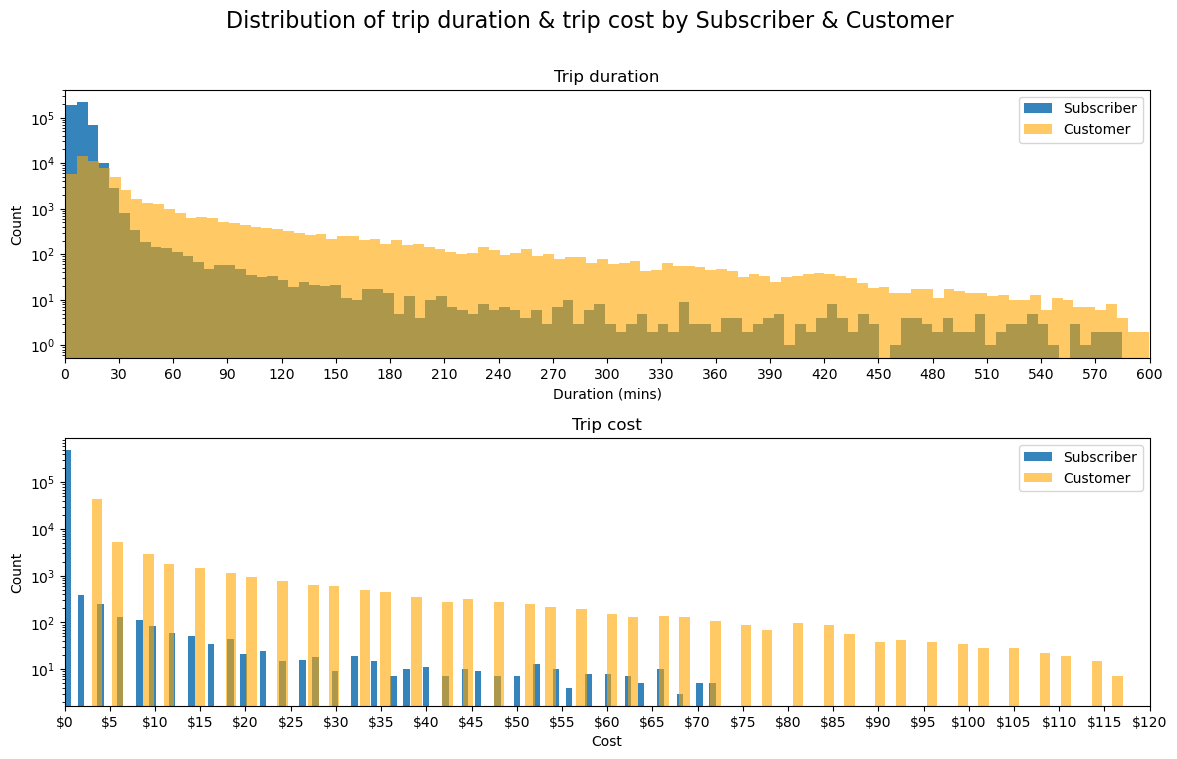

In [10]:
# Plot - Distribution of trip duration and trip cost
fig = plt.figure(figsize = (14,8))
fig.suptitle('Distribution of trip duration & trip cost by Subscriber & Customer',fontsize = 16)
fig.subplots_adjust(hspace=.3)

# duration
ax1 = fig.add_subplot(2,1,1)
ax1 = df1[df1.subscriber_type == 'Subscriber'].duration_min.plot(kind='hist', alpha=0.9, bins=100)
ax1 = df1[df1.subscriber_type == 'Customer'].duration_min.plot(kind='hist', alpha=0.6, bins=100, color='orange')
ax1.set_xlim((0,600))
plt.xticks(np.arange(0, 601, step=30))
ax1.set_yscale('log')
ax1.set_title('Trip duration')
ax1.set_xlabel('Duration (mins)')
ax1.set_ylabel('Count')
ax1.legend(labels=['Subscriber','Customer'])

# trip cost
ax2 = fig.add_subplot(2,1,2)
ax2 = df1[df1.subscriber_type == 'Subscriber'].trip_cost.plot(kind='hist', alpha=0.9, bins=100)
ax2 = df1[df1.subscriber_type == 'Customer'].trip_cost.plot(kind='hist', alpha=0.6, bins=100, color='orange')
ax2.set_xlim((0,120))
plt.xticks(np.arange(0, 121, step=5))
ax2.set_yscale('log')
ax2.set_title('Trip cost')
ax2.set_xlabel('Cost')
ax2.set_ylabel('Count')
fmtx = '${x:,.0f}'
tickx = mtick.StrMethodFormatter(fmtx)
ax2.xaxis.set_major_formatter(tickx)
ax2.legend(labels=['Subscriber','Customer'])

__Observations:__
* For Subscriber category: the majority of the trips happened less than 45 mins and therefore mostly free of trip charge. Not many trips extended above 45 mins.
* For Customer category:eventhough the big portion of the trip duration is less than 30 mins with trip cost $3, the spread of the trip duration and trip cost is more diverse than subscriber type.

### 1.2. Average trip cost by hours for Subscriber & Customer during weekday

In [11]:
%%bigquery df2
# Averaging trip duration (in minute) and trip cost grouping by hour for subscriber and customer category:

WITH t1 AS
    (SELECT subscriber_type, (EXTRACT(HOUR FROM start_date)) AS start_hour,
    COUNT(trip_id) AS trip_count,
    ROUND(AVG(duration_min),1) as duration, 
    ROUND(AVG(trip_cost),2) as trip_cost
    FROM
        (SELECT *
        FROM `gold-access-312519.project1.bikeshare_trips_adj`
        WHERE duration_min < 600
            AND start_date >= TIMESTAMP('2015-01-01')
            AND EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1,7)
        )
    GROUP BY subscriber_type, start_hour
    ),
t2 AS (SELECT * FROM t1 WHERE subscriber_type = 'Subscriber'),
t3 AS (SELECT * FROM t1 WHERE subscriber_type = 'Customer')
SELECT t2.start_hour, t2.trip_count AS subscriber_trip_count,
    t2.duration AS subscriber_duration, t2.trip_cost AS subscriber_trip_cost,
    t3.trip_count AS customer_trip_count, t3.duration AS customer_duration, 
    t3.trip_cost AS customer_trip_cost 
FROM t2 JOIN t3 on t2.start_hour = t3.start_hour
ORDER BY t2.start_hour;

Downloading: 100%|██████████| 24/24 [00:00<00:00, 25.15rows/s]


In [12]:
df2

,start_hour,subscriber_trip_count,subscriber_duration,subscriber_trip_cost,customer_trip_count,customer_duration,customer_trip_cost
0,0,721,9.10,0.14,180,36.70,7.15
1,1,257,8.70,0.05,120,58.00,11.00
2,2,87,8.90,0.00,58,39.70,7.40
3,3,264,10.70,0.02,29,70.70,13.14
4,4,789,7.10,0.02,43,53.90,10.67
5,5,2705,8.20,0.04,101,50.00,9.42
6,6,10927,9.00,0.04,397,35.40,6.89
7,7,38777,9.60,0.03,981,35.20,7.24
8,8,77152,9.30,0.04,2058,30.00,6.28
9,9,52686,9.00,0.05,1997,48.10,9.55


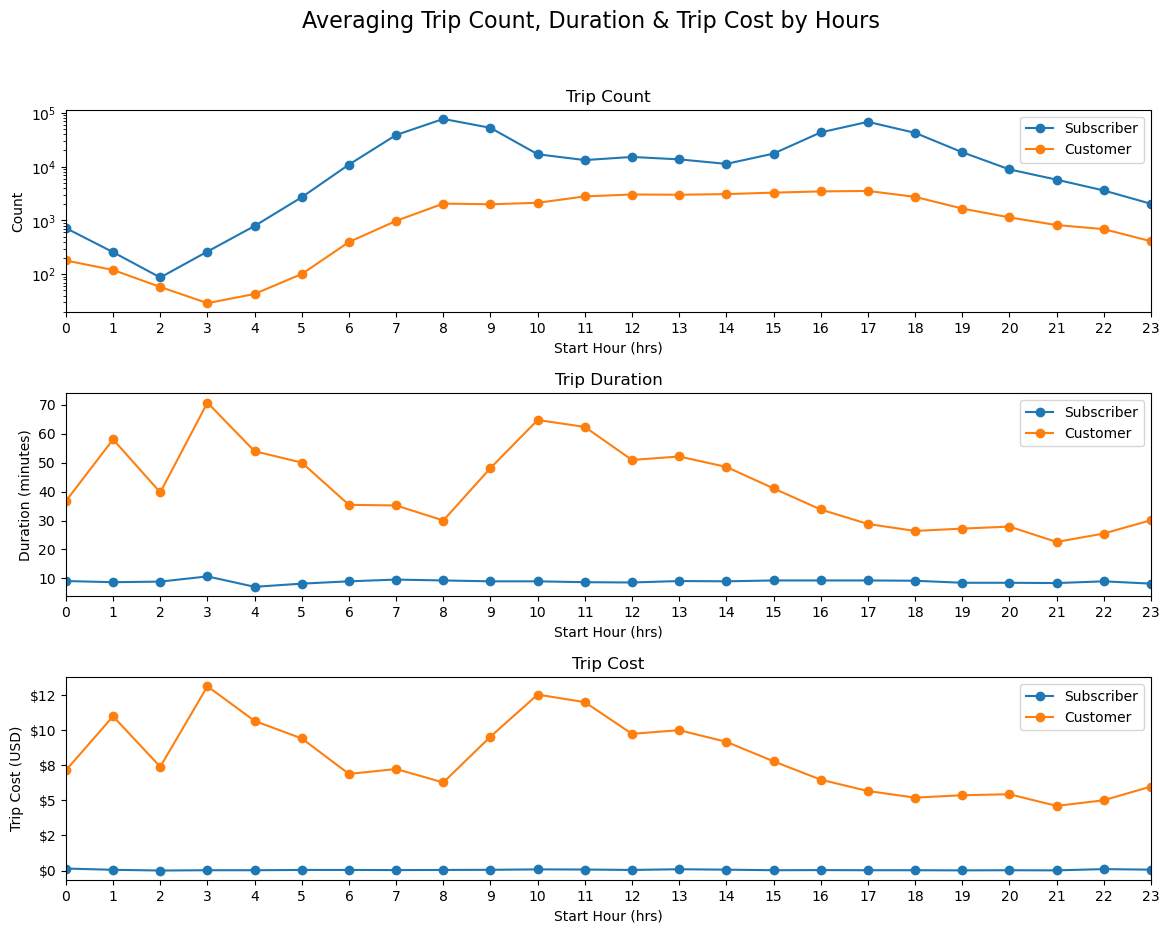

In [13]:
# Plot averaging trip count, duration & tripcost by hours
fig = plt.figure(figsize = (14,10))
fig.suptitle('Averaging Trip Count, Duration & Trip Cost by Hours',fontsize = 16)
fig.subplots_adjust(hspace=.4)

# Trip counts
ax1 = fig.add_subplot(3,1,1)
plt.plot(df2.start_hour, df2.subscriber_trip_count, marker='o')
plt.plot(df2.start_hour, df2.customer_trip_count, marker='o')
ax1.set_xlim((0,23))
plt.xticks(np.arange(0, 24))
ax1.set_yscale('log')
ax1.set_title('Trip Count')
ax1.set_xlabel('Start Hour (hrs)')
ax1.set_ylabel('Count')
ax1.legend(labels=['Subscriber','Customer'])

# Duration
ax2 = fig.add_subplot(3,1,2)
plt.plot(df2.start_hour, df2.subscriber_duration, marker='o')
plt.plot(df2.start_hour, df2.customer_duration, marker='o')
ax2.set_xlim((0,23))
plt.xticks(np.arange(0, 24))
ax2.set_title('Trip Duration')
ax2.set_xlabel('Start Hour (hrs)')
ax2.set_ylabel('Duration (minutes)')
ax2.legend(labels=['Subscriber','Customer'])

# Duration
ax3 = fig.add_subplot(3,1,3)
plt.plot(df2.start_hour, df2.subscriber_trip_cost, marker='o')
plt.plot(df2.start_hour, df2.customer_trip_cost, marker='o')
ax3.set_xlim((0,23))
plt.xticks(np.arange(0, 24))
ax3.set_title('Trip Cost')
ax3.set_xlabel('Start Hour (hrs)')
ax3.set_ylabel('Trip Cost (USD)')
fmty = '${x:,.0f}'
ticky = mtick.StrMethodFormatter(fmty)
ax3.yaxis.set_major_formatter(ticky)
ax3.legend(labels=['Subscriber','Customer'])

__Observations:__
* For Subscriber: 
    - Due to the majority of the trips were less than 15 mins, the effect of other trip durations were dampened out when taking averaging by hours. Hence, the averaging trip duration is around 10 minutes and trip cost is around \\$0 through out all hours (free of charge when a trip is less than 45 minutes). 
    - The membership price being offered is low, with \\$25 per month, and the subscribers can take unlimited free trips within 45 minutes. Meaning, if a subscriber needs to ride more than 45minutes, they could just return the bike before the 45 minutes deadline, and then take another bike or start another trip which would be free of charge since it is counted as two different trips (and both less than 45 minutes). 
    - high demand hours (most trips): from 7am to 10am and from 3pm to 6pm.
* For Customer:
    - The averaging trip duration and cost by hours are more spread out from 30 mins to 70 mins, and from \\$6 to \\$12 for trip cost
    - The demand is steady during day time (number of trips) from 7am to 8pm and seems like there is no correlation of higher demand during the commuting hours, it seems to me that customer trips were mostly related to tourism activities or others. Base on this observation, we could withdraw another assumption for defining commuter trip, which is to exclude the customer trips from the dataset. 
    
__Business Recommendations:__

To improve the revenue, I propose the two options below, given that applying two options at the same time could affect customers' satisfaction, so these changes should be incorporated one at a time:
* Membership price to be increased from \\$25 per month (or averaging of \\$1.25 per day if the subscriber rides 20 days per month) to \\$40 per month (or averaging of \\$2 per day if the subscriber rides 20 days per month). \\$2 per day for members could be considered as a fair price since for customer it is charged as $3 for the first 30 minutes.
* For membership: change from free of charge unlimited rides if a ride is within 45 minutes to free of charge for 45 minutes per day. Any overtime during the same day should be charged with \\$2 per additional trip (with 45 minutes included), and \\$2 per additional 15 minutes if within the same trip.

### 1.3. The most common commuter trips

__Assumption:__
- Commuter trip definition: commuter trips are trips having start_hour between 7am-10am and between 3pm-6pm for subscriber type, with the trip duration more than 2 minutes and less than 10 hours per trip, and it does not include weekends (Saturday & Sunday). The data includes some public holidays with the assumption that the trips happened during these holidays were not significant (or negligible) and would not affect the outcomes of the analysis.

In [14]:
%%bigquery df3
# Most common commuter trips

SELECT start_station_name, end_station_name, count(trip_id) as total_trips
FROM `gold-access-312519.project1.bikeshare_trips_adj`
WHERE EXTRACT(HOUR FROM start_date) IN (7,8,9,10,15,16,17,18)
    AND duration_min > 2 AND duration_min < 600
    AND EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7)
    AND subscriber_type = 'Subscriber'
GROUP BY start_station_name, end_station_name
ORDER BY total_trips DESC;

Downloading: 100%|██████████| 1721/1721 [00:01<00:00, 1567.52rows/s]


In [15]:
df3.head(10)

,start_station_name,end_station_name,total_trips
0,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,5825
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5823
2,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),5438
3,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),5236
4,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5114
5,Steuart at Market,San Francisco Caltrain (Townsend at 4th),4991
6,Embarcadero at Sansome,Steuart at Market,4972
7,Steuart at Market,2nd at Townsend,4884
8,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),4811
9,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),4749


### 1.4. Trip activities by month in 2014 & 2015

In [16]:
%%bigquery df4
# Trip activities by month during 2014 & 2015 (two years that have full 12 months data)

WITH t1 AS
    (SELECT subscriber_type, (EXTRACT(MONTH FROM start_date)) AS month,
        COUNT(trip_id) AS trip_count,
        ROUND(AVG(duration_min),1) as duration, 
        ROUND(AVG(trip_cost),2) as trip_cost
    FROM
        (SELECT *
        FROM `gold-access-312519.project1.bikeshare_trips_adj`
        WHERE duration_min < 600
            AND start_date >= TIMESTAMP('2014-01-01')
            AND start_date < TIMESTAMP('2016-01-01')
        )
    GROUP BY subscriber_type, month
    ),
t2 AS (SELECT * FROM t1 WHERE subscriber_type = 'Subscriber'),
t3 AS (SELECT * FROM t1 WHERE subscriber_type = 'Customer')
SELECT t2.month, t2.trip_count AS subscriber_trip_count,
    t2.duration AS subscriber_duration, t2.trip_cost AS subscriber_trip_cost,
    t3.trip_count AS customer_trip_count, t3.duration AS customer_duration, 
    t3.trip_cost AS customer_trip_cost 
FROM t2 JOIN t3 on t2.month = t3.month
ORDER BY t2.month;

Downloading: 100%|██████████| 12/12 [00:00<00:00, 12.19rows/s]


In [17]:
df4

,month,subscriber_trip_count,subscriber_duration,subscriber_trip_cost,customer_trip_count,customer_duration,customer_trip_cost
0,1,46064,8.90,0.04,6114,46.70,8.99
1,2,40236,9.00,0.06,5092,45.00,8.67
2,3,48314,9.10,0.04,7794,47.50,9.06
3,4,50153,9.00,0.04,7333,47.90,9.23
4,5,48902,9.00,0.04,9024,47.10,9.08
5,6,52983,9.10,0.04,8750,45.40,8.73
6,7,53761,9.20,0.04,9880,48.40,9.27
7,8,52802,9.10,0.03,10211,47.30,9.09
8,9,54219,9.30,0.05,7767,48.20,9.25
9,10,57343,9.30,0.05,7848,44.50,8.55


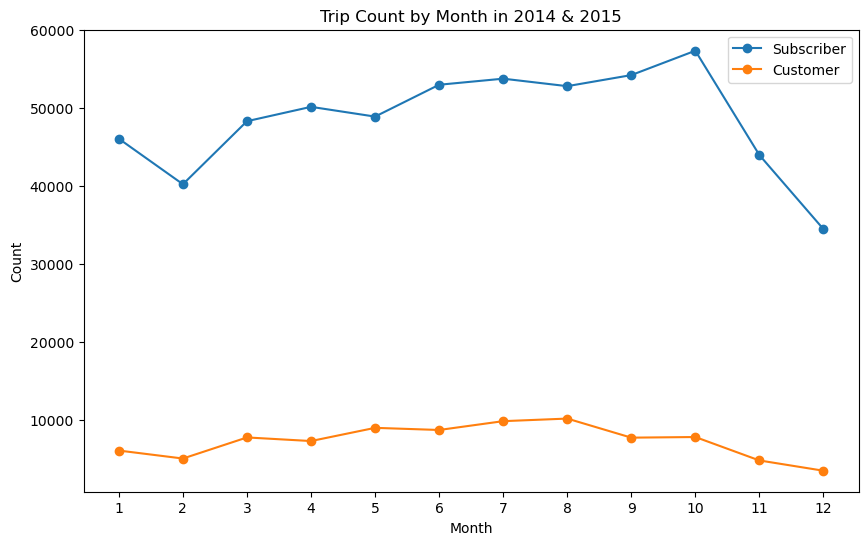

In [18]:
# Plot trip count by month
fig, ax = plt.subplots(1,1, figsize = (10,6))
plt.plot(df4.month, df4.subscriber_trip_count, marker='o')
plt.plot(df4.month, df4.customer_trip_count, marker='o')
plt.xticks(np.arange(1, 13))
ax.set_title('Trip Count by Month in 2014 & 2015')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
ax.legend(labels=['Subscriber','Customer'])

__Observations:__

The trip count during winter months (November to Febuary) is lower than the rest of the year which show how the weather could affect people decision in riding bikes. The trip count is especially low in November and December for Subscriber type, which was mostly related to the Thanks Giving and Christmas Holiday and less commuter trips. 
    
__Business Recommendations:__

* To improve the bike share activities during the low demand season, we could offer promotions to customer type during the end of November until the end of December, for example extending the time from 30 minutes to 45 minutes with unlock fee. 
* From section 1 result, we also see that the bike activities during weekend (Saturday and Sunday) is very low comparing to the weekdays. So we could offer the above promotions to customers during weekends as well.
* The promotion could be an advertisement campaign to make more people aware about bikeshare in the Bay Area. 

## 2. Utilization exploratory

### 2.1 Trip activities and averaging bike availabiltiy, utilization during the high demand hours for each station

- Assumption: 
    * high demand hours is from 7am to 9am, and from 4pm to 6pm during weekdays.
    * As the number of docks available could reflect how many bikes were rent in a station, we could calculate the bike utilization rate (percent) as:
    $$bike~utilization~rate = \frac{docks~available}{dock~count}100$$

In [19]:
%%bigquery df5

WITH t1 AS
    (SELECT start_station_name AS station_name, start_station_id AS station_id,
         COUNT(trip_id) as outgoing_trips
     FROM `gold-access-312519.project1.bikeshare_trips_adj`
     WHERE (EXTRACT(HOUR FROM start_date) IN(7,8,9,16,17,18))
          AND duration_min <600
          AND EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7)
     GROUP BY station_name, station_id 
    ),
    t2 AS
    (SELECT end_station_id AS station_id,
         COUNT(trip_id) as incoming_trips
     FROM `gold-access-312519.project1.bikeshare_trips_adj`
     WHERE (EXTRACT(HOUR FROM start_date) IN (7,8,9,16,17,18))
          AND duration_min <600
          AND EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7)
     GROUP BY station_id
    ),
    t3 AS
    (SELECT station_id, ROUND(AVG(bikes_available),0) AS bikes_available,
         ROUND(AVG(docks_available),0) AS docks_available
    FROM (SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_status`
        WHERE EXTRACT(HOUR FROM time) IN (7,8,9,10,15,16,17,18)
            AND EXTRACT(DAYOFWEEK FROM time) NOT IN (1,7))
    GROUP BY station_id
    )
SELECT t1.station_name, t1.station_id, t1.outgoing_trips, t2.incoming_trips,
    (t1.outgoing_trips + t2.incoming_trips) AS total_in_out_trips,
    (t1.outgoing_trips - t2.incoming_trips) AS out_in_difference,
    t3.bikes_available, t3.docks_available, t4.dockcount,
    ROUND(100*t3.docks_available/ t4.dockcount,2) AS utilization_rate
FROM ((t1 JOIN t2 ON t1.station_id = t2.station_id)
    JOIN t3 ON t1.station_id = t3.station_id)
    JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS t4
    ON t1.station_id = t4.station_id
ORDER BY total_in_out_trips DESC

Downloading: 100%|██████████| 74/74 [00:00<00:00, 75.60rows/s] 


In [20]:
# Top 20 stations with the most activities
df5.head(20)

,station_name,station_id,outgoing_trips,incoming_trips,total_in_out_trips,out_in_difference,bikes_available,docks_available,dockcount,utilization_rate
0,San Francisco Caltrain (Townsend at 4th),70,52418,65389,117807,-12971,8.00,11.00,19,57.89
1,San Francisco Caltrain 2 (330 Townsend),69,40256,42086,82342,-1830,10.00,13.00,23,56.52
2,Harry Bridges Plaza (Ferry Building),50,27284,26842,54126,442,11.00,12.00,23,52.17
3,Temporary Transbay Terminal (Howard at Beale),55,28869,24414,53283,4455,9.00,14.00,23,60.87
4,2nd at Townsend,61,24090,26815,50905,-2725,12.00,14.00,27,51.85
5,Steuart at Market,74,25302,25507,50809,-205,10.00,13.00,23,56.52
6,Townsend at 7th,65,20315,23971,44286,-3656,7.00,8.00,15,53.33
7,Market at Sansome,77,18871,23793,42664,-4922,14.00,13.00,27,48.15
8,Embarcadero at Sansome,60,18575,20076,38651,-1501,7.00,8.00,15,53.33
9,Market at 10th,67,17264,13680,30944,3584,9.00,17.00,27,62.96


In [21]:
# Top 10 stations that have more bikes outgoing than incoming during high demand hours:
df5.sort_values('out_in_difference', ascending=False).head(10)

,station_name,station_id,outgoing_trips,incoming_trips,total_in_out_trips,out_in_difference,bikes_available,docks_available,dockcount,utilization_rate
27,Grant Avenue at Columbus Avenue,73,12273,4391,16664,7882,7.00,9.00,19,47.37
17,2nd at Folsom,62,13444,7635,21079,5809,6.00,12.00,19,63.16
3,Temporary Transbay Terminal (Howard at Beale),55,28869,24414,53283,4455,9.00,14.00,23,60.87
9,Market at 10th,67,17264,13680,30944,3584,9.00,17.00,27,62.96
33,Powell at Post (Union Square),71,7298,4078,11376,3220,8.00,11.00,19,57.89
13,Beale at Market,56,13838,10772,24610,3066,8.00,11.00,19,57.89
22,Embarcadero at Bryant,54,10678,7815,18493,2863,7.00,8.00,15,53.33
21,South Van Ness at Market,66,10651,7870,18521,2781,7.00,12.00,19,63.16
24,Broadway St at Battery St,82,9805,8142,17947,1663,6.00,9.00,15,60.00
10,2nd at South Park,64,15163,13530,28693,1633,7.00,8.00,15,53.33


In [22]:
# Top 10 stations that have more bikes incoming than outgoing during the high demand hours:
df5.sort_values('out_in_difference').head(10)

,station_name,station_id,outgoing_trips,incoming_trips,total_in_out_trips,out_in_difference,bikes_available,docks_available,dockcount,utilization_rate
0,San Francisco Caltrain (Townsend at 4th),70,52418,65389,117807,-12971,8.00,11.00,19,57.89
7,Market at Sansome,77,18871,23793,42664,-4922,14.00,13.00,27,48.15
6,Townsend at 7th,65,20315,23971,44286,-3656,7.00,8.00,15,53.33
4,2nd at Townsend,61,24090,26815,50905,-2725,12.00,14.00,27,51.85
1,San Francisco Caltrain 2 (330 Townsend),69,40256,42086,82342,-1830,10.00,13.00,23,56.52
14,Powell Street BART,39,10836,12664,23500,-1828,9.00,10.00,19,52.63
8,Embarcadero at Sansome,60,18575,20076,38651,-1501,7.00,8.00,15,53.33
28,Embarcadero at Vallejo,48,7293,8788,16081,-1495,7.00,8.00,15,53.33
16,5th at Howard,57,9974,11408,21382,-1434,7.00,8.00,15,53.33
30,Yerba Buena Center of the Arts (3rd @ Howard),68,7130,8416,15546,-1286,9.00,10.00,19,52.63


In [23]:
# Top 10 stations that have the least activities
df5.sort_values('total_in_out_trips').head(10)

,station_name,station_id,outgoing_trips,incoming_trips,total_in_out_trips,out_in_difference,bikes_available,docks_available,dockcount,utilization_rate
73,5th S. at E. San Salvador St,88,7,17,24,-10,9.00,10.00,19,52.63
72,S. Market st at Park Ave,89,16,15,31,1,6.00,13.00,19,68.42
71,Cyril Magnin St at Ellis St,91,33,27,60,6,5.00,30.00,35,85.71
70,5th St at Folsom St,90,82,88,170,-6,12.00,19.00,31,61.29
69,Franklin at Maple,21,84,96,180,-12,6.00,9.00,15,60.00
68,Redwood City Public Library,24,76,131,207,-55,7.00,8.00,15,53.33
67,San Mateo County Center,23,80,172,252,-92,7.00,8.00,15,53.33
66,Mezes Park,83,309,177,486,132,6.00,9.00,15,60.00
65,Redwood City Medical Center,26,315,361,676,-46,7.00,8.00,15,53.33
64,University and Emerson,35,420,555,975,-135,6.00,5.00,11,45.45


In [24]:
%%bigquery df6

# From the top 10 station with lowest activities, station 90 & 91 have many dock counts compare to other stations
# However, they have very low trip counts compare to others. Further check the oldest and latest trip records
# confirms that station 90 & 91 were actually just new stations. And it's not because they have more docks than needed.
SELECT * FROM `gold-access-312519.project1.bikeshare_trips_adj`
WHERE start_station_id = 90

Downloading: 100%|██████████| 173/173 [00:01<00:00, 101.00rows/s]


In [25]:
df6.start_date.min(), df6.start_date.max()

(Timestamp('2016-08-04 14:26:00+0000', tz='UTC'),
 Timestamp('2016-08-31 19:48:00+0000', tz='UTC'))

__Observations:__

* From the top 20 stations with the most activities, there are some stations have low dock count like station 70 (19 docks), and 65, 60, 64, 57 (only 15 docks). 
* Some stations have a lot more outgoing trips than incomming trips, which potentially have low bike availabiltiy during the high demand hours as well. These station are 73, 62, 55, 67, 71, 56, 54, 66, 82, 64.
* Therefore further study of the bike availability for the above stations will be needed to confirm if they were running low on bike availability during the high demand hours.

### 2.2. Bike availability by hours for selected stations 

In [26]:
%%bigquery df7
## first half of the stations
WITH t1 AS
    (SELECT  station_id, (EXTRACT(HOUR FROM time)) AS hour,
      ROUND(AVG(bikes_available),0) AS bikes_available
    FROM
      (SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_status`
      WHERE EXTRACT(DAYOFWEEK FROM time) NOT IN (1,7)
        AND time >= TIMESTAMP('2015-01-01'))
    GROUP BY station_id, hour
    HAVING station_id <= 46
    ),
    t2 AS
    (SELECT start_station_id, COUNT(trip_id) AS out_going_trips
     FROM (SELECT * FROM `gold-access-312519.project1.bikeshare_trips_adj`
      WHERE (EXTRACT(HOUR FROM start_date) BETWEEN 6 AND 19)
          AND duration_min > 2 AND duration_min < 600
          AND EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7))
     GROUP BY start_station_id
    )
SELECT t1.*, t2.out_going_trips
FROM t1 JOIN t2 ON t1.station_id = t2.start_station_id
ORDER BY t2.out_going_trips DESC

Downloading: 100%|██████████| 888/888 [00:01<00:00, 882.49rows/s]


In [29]:
%%bigquery df8
## second half of the stations
WITH t1 AS
    (SELECT  station_id, (EXTRACT(HOUR FROM time)) AS hour,
      ROUND(AVG(bikes_available),0) AS bikes_available
    FROM
      (SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_status`
      WHERE EXTRACT(DAYOFWEEK FROM time) NOT IN (1,7)
        AND time >= TIMESTAMP('2015-01-01'))
    GROUP BY station_id, hour
    HAVING station_id > 46
    ),
    t2 AS
    (SELECT start_station_id, COUNT(trip_id) AS out_going_trips
     FROM (SELECT * FROM `gold-access-312519.project1.bikeshare_trips_adj`
      WHERE (EXTRACT(HOUR FROM start_date) BETWEEN 6 AND 19)
          AND duration_min > 2 AND duration_min < 600
          AND EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7))
     GROUP BY start_station_id
    )
SELECT t1.*, t2.out_going_trips
FROM t1 JOIN t2 ON t1.station_id = t2.start_station_id
ORDER BY t2.out_going_trips DESC

Downloading: 100%|██████████| 888/888 [00:00<00:00, 940.59rows/s]


In [27]:
df7.head(10)

,station_id,hour,bikes_available,out_going_trips
0,39,21,11.00,18729
1,39,19,11.00,18729
2,39,22,11.00,18729
3,39,0,11.00,18729
4,39,18,9.00,18729
5,39,3,11.00,18729
6,39,20,11.00,18729
7,39,2,11.00,18729
8,39,17,8.00,18729
9,39,4,11.00,18729


Text(0.5, 1.0, 'Bikes Availabitly by Hours for stations 2 to 46')

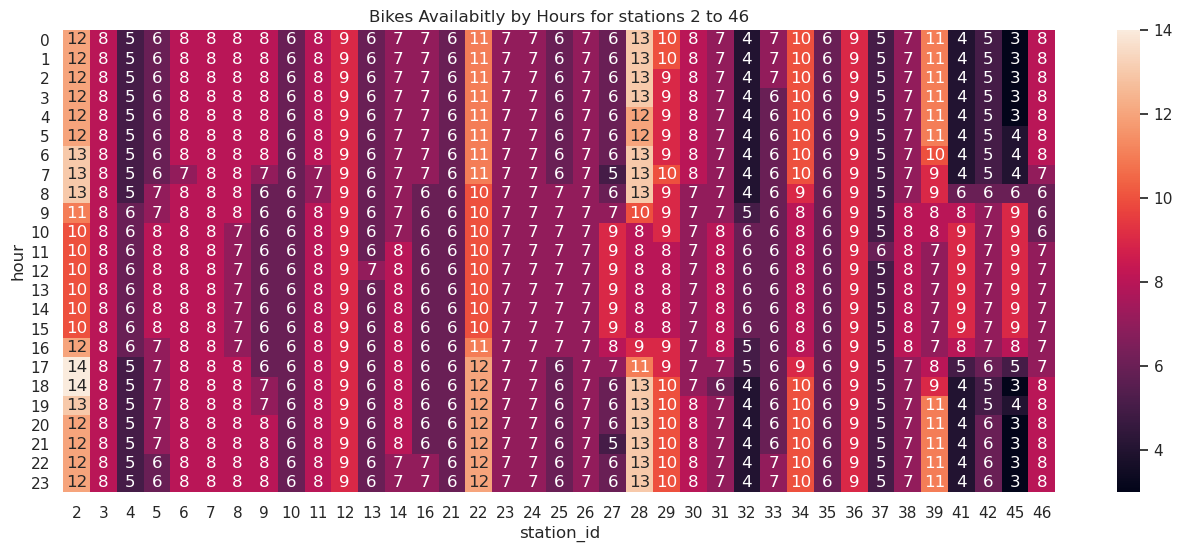

In [28]:
# Plot the averaging bike availability by hours for stations_id 2 to 46
pivot = df7.pivot(index='hour', columns='station_id', values='bikes_available')
sns.set(rc={'figure.figsize':(16,6)})
sns.set(style = 'white')
sns.heatmap(pivot, annot = True)
plt.title('Bikes Availabitly by Hours for stations 2 to 46')

Text(0.5, 1.0, 'Bikes Availabitly by Hours for stations 47 to 99')

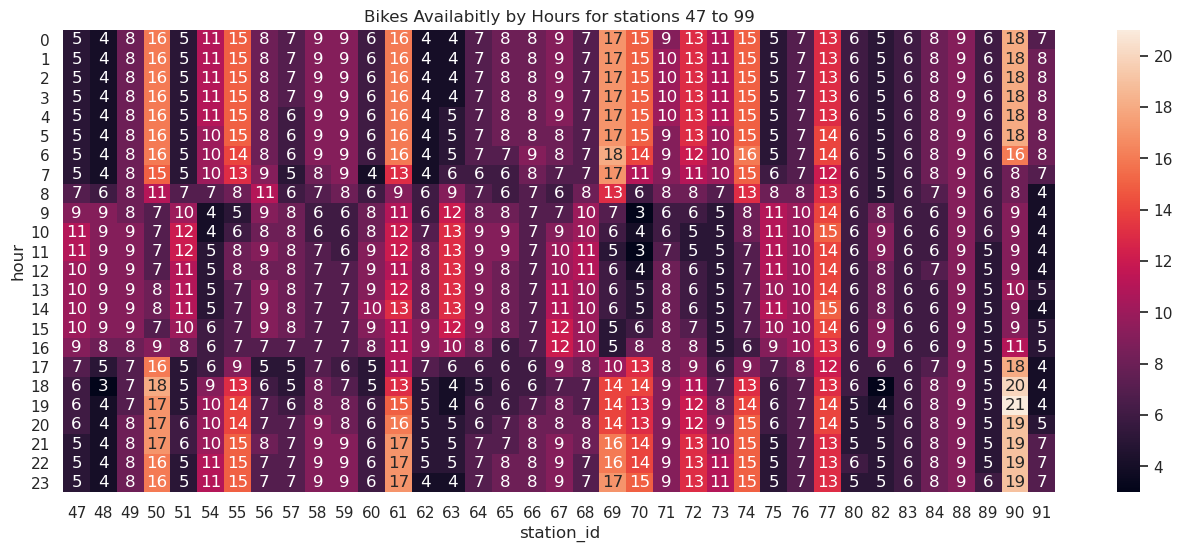

In [30]:
# Plot the averaging bike availability by hours for stations_id 47 to 99
pivot = df8.pivot(index='hour', columns='station_id', values='bikes_available')
sns.set(rc={'figure.figsize':(16,6)})
sns.set(style = 'white')
sns.heatmap(pivot, annot = True)
plt.title('Bikes Availabitly by Hours for stations 47 to 99')

__Observations:__

* When the averaging bike availability by hour is less than 5, the stations are mostly running low on bikes. Some stations having low bike availability during day time (from 8am to 6pm) like stations 54, 70, 73 and 91. Whereas, the some stations having high bike availability during day time but low bike availability during night time like stations 41, 45, 48, 62, 63.

__Business Recommendations:__

* To improve the bike availability for these stations during the correct hours. I would propose promotions like discount 1/2 price offered to non-subscribers (customers) when riding the bike from stations 41, 45, 48, 62, 63 to stations 54, 70, 73, 91 from 8am-10am. And offer the discount for the oposite direction from stations 54, 70, 73, 91 to stations 41, 45, 48, 62, 63 from 5-6pm.


## 3. Summary

__Top 5 commuter trips:__

|               start_station_name              |             end_station_name             | total_trips |
|:---------------------------------------------:|:----------------------------------------:|:-----------:|
|    San Francisco Caltrain 2 (330 Townsend)    |              Townsend at 7th             |     5825    |
|                2nd at Townsend                |   Harry Bridges Plaza (Ferry Building)   |     5823    |
|             Embarcadero at Folsom             | San Francisco Caltrain (Townsend at 4th) |     5438    |
| Temporary Transbay Terminal (Howard at Beale) | San Francisco Caltrain (Townsend at 4th) |     5236    |
|      Harry Bridges Plaza (Ferry Building)     |              2nd at Townsend             |     5114    |

__Business Recommendations:__
* Two options to improve revenue:
    - Membership price to be increased from \\$25 per month to \\$40 per month.
    - Or change from free of charge unlimited rides if a trip is within 45 minutes for membership to free of charge for 45 minutes per day only. Any overtime during the same day should be charged with \\$2 per additional trip (with 45 minutes included), and \\$2 per additional 15 minutes if within the same trip.
* To improve bike share activities during the low demand season and weekends: offer promotions to non-subscribers during weekends, and from the end of November until the end of December, for example extending the time from 30 minutes to 45 minutes with unlock fee.  
* To improve the bike availability for stations with high demands during the right hours. offer promotions (i.e. discount 1/2 price) to non-subscribers when riding the bike from stations 41, 45, 48, 62, 63 to stations 54, 70, 73, 91 from 8am-10am. And offer the discount for the oposite direction from stations 54, 70, 73, 91 to stations 41, 45, 48, 62, 63 from 5-6pm.